In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import tensorflow_datasets as tfds
from keras.models import Model, Sequential
from keras.layers import Dense, Input
from keras.layers import Dropout
from keras.layers import BatchNormalization, Reshape, Conv2DTranspose, Conv2D, Flatten
from keras.layers import LeakyReLU
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import time


In [2]:
Z_DIM = 100
BATCH_SIZE = 1024
EPOCHS = 1000


def generate_z(size):
    return tf.random.uniform((size, Z_DIM), -1, 1)



In [3]:
ds = tfds.load("mnist", split="train", shuffle_files=True)
assert isinstance(ds, tf.data.Dataset)
ds = ds.map(lambda x: (tf.cast(x["image"], tf.float32) - 127.5) / 127.5)

In [4]:
def create_generator():
    generator = Sequential()
    generator.add(Dense(units=256 * 7 * 7, input_dim=Z_DIM, use_bias=False))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    generator.add(Reshape((7, 7, 256)))
    generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"))
    generator.compile()

    return generator


g = create_generator()
g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [5]:
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1]))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))
    discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation="sigmoid"))
    discriminator.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return discriminator


d = create_discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [6]:
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(Z_DIM,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return gan


gan = create_gan(d, g)
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         2330944   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 2,543,809
Trainable params: 2,305,472
Non-trainable params: 238,337
_________________________________________________________________


In [7]:
def plot_generated_images(generator):
    noise = generate_z(10)
    generated_images = generator.predict(noise, verbose=0)
    generated_images = generated_images.reshape(10, 28, 28)
    plt.figure(figsize=(10, 1))
    for i in range(generated_images.shape[0]):
        plt.subplot(1, 10, i + 1)
        plt.imshow(generated_images[i], interpolation="nearest", cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.show()



2023-08-17 01:29:51.552166: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-08-17 01:29:54.382606: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-08-17 01:30:13.224886: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-08-17 01:30:15.002324: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape 

Epoch: 0, Time: 27.29710555076599, BPS: 2.198035241810329, Generator Loss: 0.1155403061978069, Discriminator Loss: 0.27692176063813395


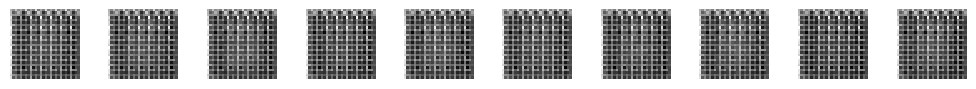

Epoch: 5, Time: 14.608429908752441, BPS: 4.107217570592704, Generator Loss: 1.0928216422637318e-06, Discriminator Loss: 0.00015512921539593045
Epoch: 10, Time: 14.903020143508911, BPS: 4.026029584757242, Generator Loss: 0.6267010468547627, Discriminator Loss: 0.7001056590322721


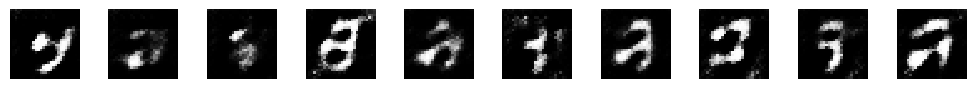

Epoch: 15, Time: 14.649028539657593, BPS: 4.095834740001295, Generator Loss: 0.6917287788148654, Discriminator Loss: 0.6829514826758433
Epoch: 20, Time: 14.65058946609497, BPS: 4.095398355052853, Generator Loss: 0.7117297699895956, Discriminator Loss: 0.6895870626982996


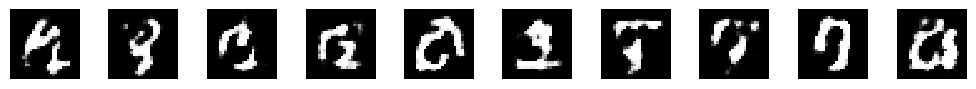

Epoch: 25, Time: 14.64387059211731, BPS: 4.097277398251359, Generator Loss: 0.7298833950091217, Discriminator Loss: 0.6844492009130575
Epoch: 30, Time: 14.696847438812256, BPS: 4.082508187541544, Generator Loss: 0.7301752739033457, Discriminator Loss: 0.6806012179891942


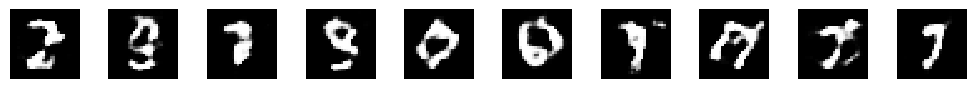

Epoch: 35, Time: 14.638885021209717, BPS: 4.098672809648297, Generator Loss: 0.7504279168985658, Discriminator Loss: 0.6858406117406942
Epoch: 40, Time: 14.675463438034058, BPS: 4.0884569167675755, Generator Loss: 0.7460919739836354, Discriminator Loss: 0.6815829610420485


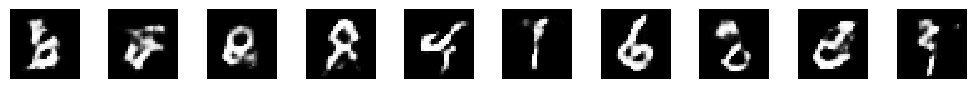

Epoch: 45, Time: 14.681404113769531, BPS: 4.0868025656842075, Generator Loss: 0.7254873837454844, Discriminator Loss: 0.6805587956460856
Epoch: 50, Time: 14.639891147613525, BPS: 4.098391128391738, Generator Loss: 0.7250573261309479, Discriminator Loss: 0.6813898268392531


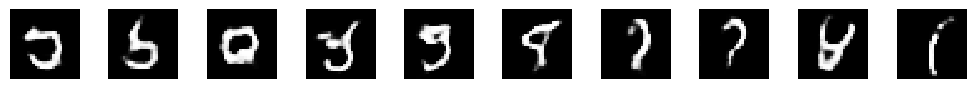

Epoch: 55, Time: 14.636482238769531, BPS: 4.099345663882971, Generator Loss: 0.7239734439526574, Discriminator Loss: 0.6812583905155376
Epoch: 60, Time: 14.68313193321228, BPS: 4.086321656232206, Generator Loss: 0.7334206205303386, Discriminator Loss: 0.6807994620274689


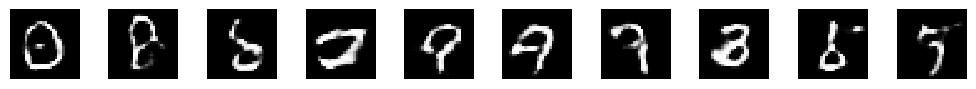

Epoch: 65, Time: 14.673835039138794, BPS: 4.088910624929677, Generator Loss: 0.7354680926112805, Discriminator Loss: 0.6746450551485611
Epoch: 70, Time: 14.627840518951416, BPS: 4.101767442861146, Generator Loss: 0.7381985157223071, Discriminator Loss: 0.6723083186957796


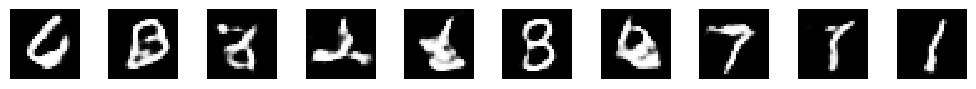

Epoch: 75, Time: 14.593715906143188, BPS: 4.1113586413411785, Generator Loss: 0.736778554269823, Discriminator Loss: 0.6728349863472631
Epoch: 80, Time: 14.594639778137207, BPS: 4.111098383522976, Generator Loss: 0.7497530377517312, Discriminator Loss: 0.673782393083734


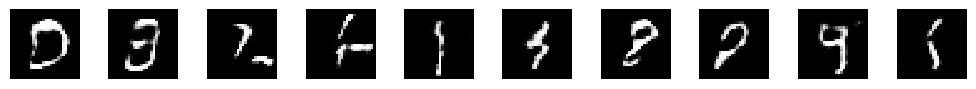

Epoch: 85, Time: 14.61102819442749, BPS: 4.10648718225617, Generator Loss: 0.7988542500188796, Discriminator Loss: 0.6785643525042776
Epoch: 90, Time: 14.60927963256836, BPS: 4.10697868129257, Generator Loss: 0.7687116790626009, Discriminator Loss: 0.6706596653340227


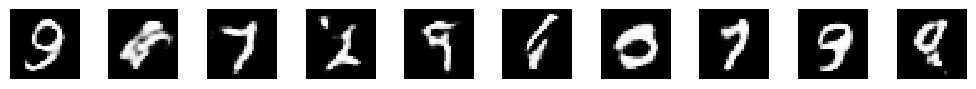

Epoch: 95, Time: 14.584291934967041, BPS: 4.114015289020995, Generator Loss: 0.7643223910008446, Discriminator Loss: 0.6725167813947646
Epoch: 100, Time: 14.6197190284729, BPS: 4.104046041045379, Generator Loss: 0.7687710927704633, Discriminator Loss: 0.6701965907872733


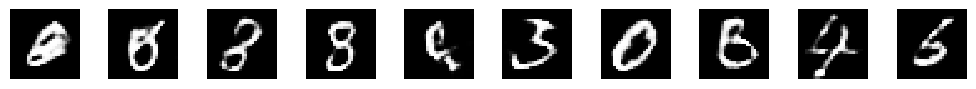

Epoch: 105, Time: 14.596034049987793, BPS: 4.110705674878182, Generator Loss: 0.767534907591545, Discriminator Loss: 0.6665102617215302
Epoch: 110, Time: 14.607656717300415, BPS: 4.107434967919233, Generator Loss: 0.7665260898864875, Discriminator Loss: 0.6682190137394404


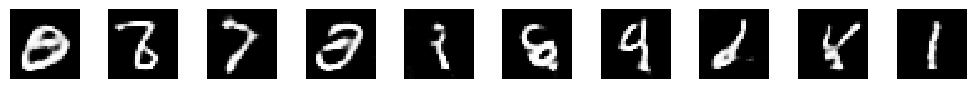

Epoch: 115, Time: 14.590544700622559, BPS: 4.112252231230262, Generator Loss: 0.7794199585914612, Discriminator Loss: 0.6669814586639404
Epoch: 120, Time: 14.60326337814331, BPS: 4.108670674926122, Generator Loss: 0.8007060319690381, Discriminator Loss: 0.6712452870304302


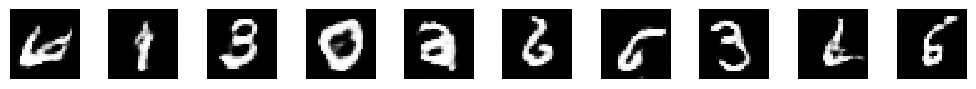

Epoch: 125, Time: 14.60619854927063, BPS: 4.107845021933934, Generator Loss: 0.7746699209940635, Discriminator Loss: 0.667651392645755
Epoch: 130, Time: 14.59733510017395, BPS: 4.110339290579485, Generator Loss: 0.7713617571329666, Discriminator Loss: 0.665561257782629


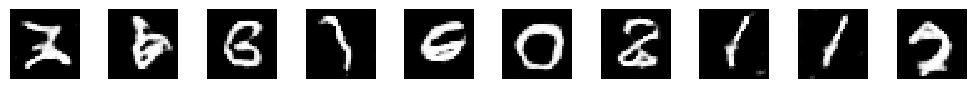

Epoch: 135, Time: 14.643547534942627, BPS: 4.097367789931177, Generator Loss: 0.7875330842147439, Discriminator Loss: 0.6705921403432297
Epoch: 140, Time: 14.652382135391235, BPS: 4.094897296943719, Generator Loss: 0.7761090003837974, Discriminator Loss: 0.6665040052543252


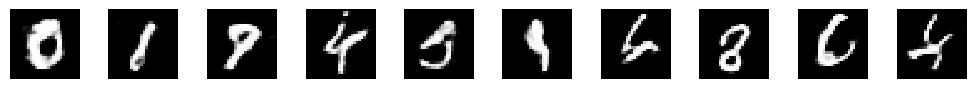

Epoch: 145, Time: 14.612541437149048, BPS: 4.10606192345595, Generator Loss: 0.7901448708469585, Discriminator Loss: 0.6689144696219492
Epoch: 150, Time: 14.675354719161987, BPS: 4.088487205127414, Generator Loss: 0.7791527206614867, Discriminator Loss: 0.6690741070246292


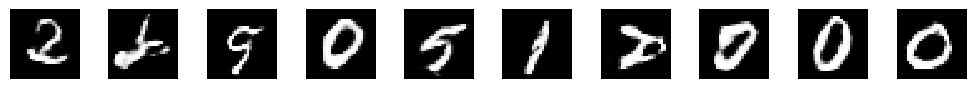

Epoch: 155, Time: 14.62742567062378, BPS: 4.101883773061848, Generator Loss: 0.7734557885234639, Discriminator Loss: 0.6676678425174648
Epoch: 160, Time: 14.577187776565552, BPS: 4.116020244759189, Generator Loss: 0.7878235507819612, Discriminator Loss: 0.6696814500679404


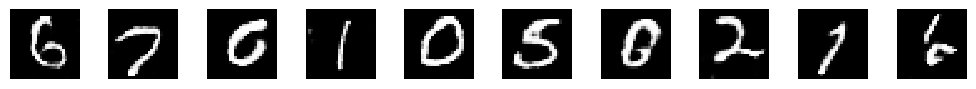

Epoch: 165, Time: 14.591633558273315, BPS: 4.111945366526874, Generator Loss: 0.7920934850886717, Discriminator Loss: 0.6715113611544593
Epoch: 170, Time: 14.586956262588501, BPS: 4.1132638584708285, Generator Loss: 0.7935030692714756, Discriminator Loss: 0.6724518093012147


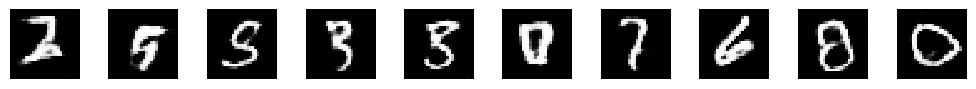

Epoch: 175, Time: 14.611747980117798, BPS: 4.1062848936104, Generator Loss: 0.7725929011732845, Discriminator Loss: 0.6674741658113771
Epoch: 180, Time: 14.650681018829346, BPS: 4.095372762732791, Generator Loss: 0.7796262401645466, Discriminator Loss: 0.6690426923460879


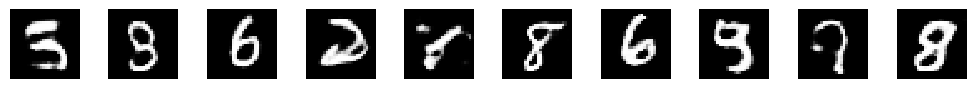

Epoch: 185, Time: 14.608843326568604, BPS: 4.107101339835718, Generator Loss: 0.7876663389852492, Discriminator Loss: 0.6694679219843978
Epoch: 190, Time: 14.596602201461792, BPS: 4.1105456716489295, Generator Loss: 0.8019238538661245, Discriminator Loss: 0.6740251082485005


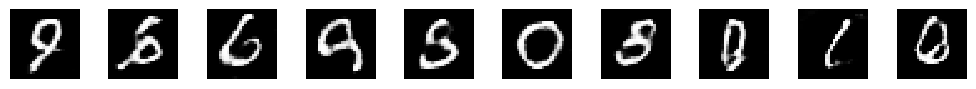

Epoch: 195, Time: 14.612784624099731, BPS: 4.105993590095529, Generator Loss: 0.7743352712210962, Discriminator Loss: 0.6695736808291937
Epoch: 200, Time: 14.583231210708618, BPS: 4.114314525572452, Generator Loss: 0.7737774707503238, Discriminator Loss: 0.6694783447152477


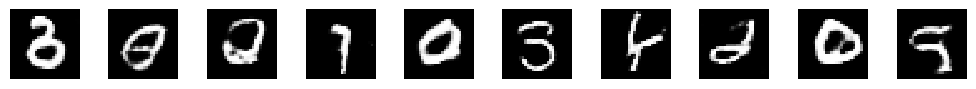

Epoch: 205, Time: 14.57575535774231, BPS: 4.11642474282675, Generator Loss: 0.7769876668008707, Discriminator Loss: 0.6715108863377975
Epoch: 210, Time: 14.582124471664429, BPS: 4.114626789573104, Generator Loss: 0.7658396221823611, Discriminator Loss: 0.6700740193916579


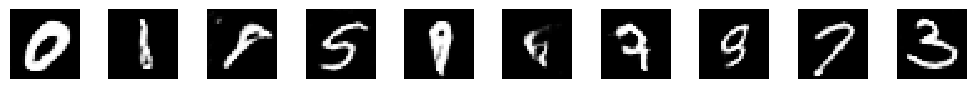

Epoch: 215, Time: 14.521757125854492, BPS: 4.131731406881622, Generator Loss: 0.7886253393302529, Discriminator Loss: 0.6743724578517979
Epoch: 220, Time: 14.532060384750366, BPS: 4.128802001329606, Generator Loss: 0.7704381538649737, Discriminator Loss: 0.6721174787666838


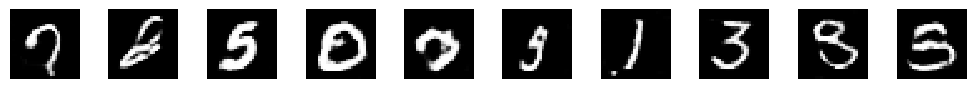

Epoch: 225, Time: 14.593544006347656, BPS: 4.1114070697222145, Generator Loss: 0.7727771653967389, Discriminator Loss: 0.673426609928325
Epoch: 230, Time: 14.549920558929443, BPS: 4.123733855246196, Generator Loss: 0.7836309095560494, Discriminator Loss: 0.6742858199749963


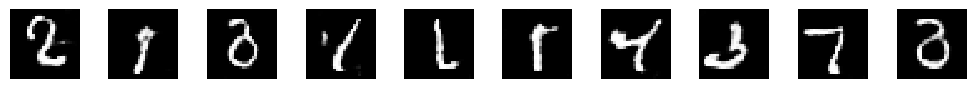

Epoch: 235, Time: 14.525038719177246, BPS: 4.130797938650771, Generator Loss: 0.7647953882055768, Discriminator Loss: 0.6698172375307245
Epoch: 240, Time: 14.562714338302612, BPS: 4.120111031924109, Generator Loss: 0.7798043590480999, Discriminator Loss: 0.6734847689079027


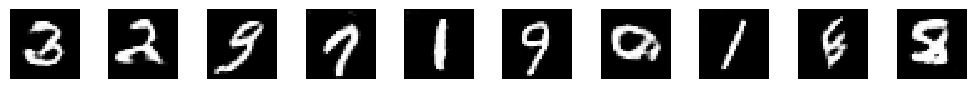

Epoch: 245, Time: 14.534294605255127, BPS: 4.12816731940372, Generator Loss: 0.7738547981795618, Discriminator Loss: 0.6722899927931317
Epoch: 250, Time: 14.537468433380127, BPS: 4.127266055638088, Generator Loss: 0.780797233015804, Discriminator Loss: 0.6748038671784482


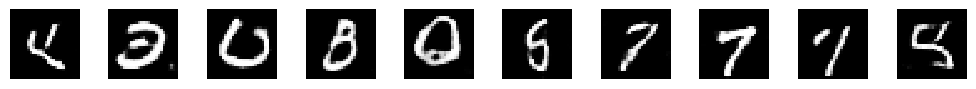

Epoch: 255, Time: 14.558347702026367, BPS: 4.121346819574081, Generator Loss: 0.7677964911622516, Discriminator Loss: 0.6733823711589232
Epoch: 260, Time: 14.580084085464478, BPS: 4.115202604340027, Generator Loss: 0.7742588641279835, Discriminator Loss: 0.6739285871133966


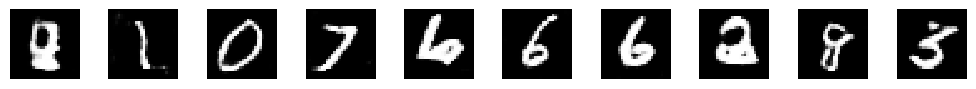

Epoch: 265, Time: 14.50139594078064, BPS: 4.13753270685264, Generator Loss: 0.771532084982274, Discriminator Loss: 0.6735421398938712
Epoch: 270, Time: 14.513500690460205, BPS: 4.134081864855547, Generator Loss: 0.7649620427923688, Discriminator Loss: 0.6723130062475042


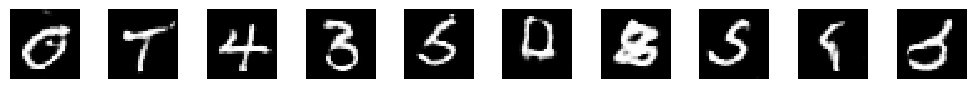

Epoch: 275, Time: 14.522863626480103, BPS: 4.131416609228476, Generator Loss: 0.7766871563458847, Discriminator Loss: 0.6736731327186196
Epoch: 280, Time: 14.563859462738037, BPS: 4.119787076599534, Generator Loss: 0.7709160689580239, Discriminator Loss: 0.6731935284905515


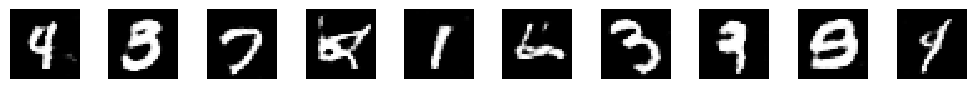

Epoch: 285, Time: 14.53208065032959, BPS: 4.1287962435468035, Generator Loss: 0.768243782601114, Discriminator Loss: 0.6721393536713164
Epoch: 290, Time: 14.53431749343872, BPS: 4.128160818496363, Generator Loss: 0.7668253951153513, Discriminator Loss: 0.6734599400374849


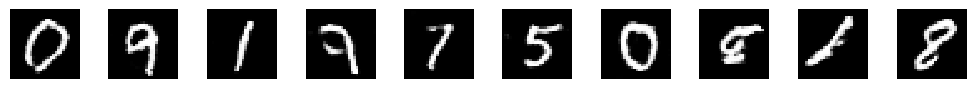

Epoch: 295, Time: 14.52609896659851, BPS: 4.130496435275894, Generator Loss: 0.7813302591695623, Discriminator Loss: 0.6761397901227919
Epoch: 300, Time: 14.52792239189148, BPS: 4.129978009346196, Generator Loss: 0.7619923979549085, Discriminator Loss: 0.67146105988551


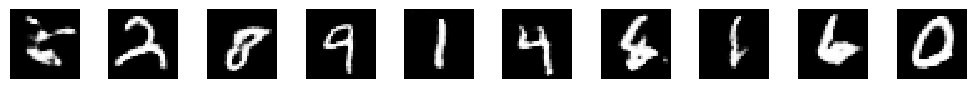

Epoch: 305, Time: 14.533456087112427, BPS: 4.128405496969515, Generator Loss: 0.7678855051428585, Discriminator Loss: 0.675659361532179
Epoch: 310, Time: 14.522167921066284, BPS: 4.131614530703934, Generator Loss: 0.7655083678536496, Discriminator Loss: 0.6733275571111905


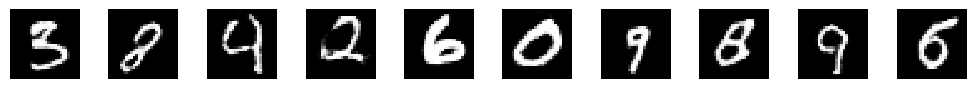

Epoch: 315, Time: 14.55666446685791, BPS: 4.121823384512698, Generator Loss: 0.7714825121022887, Discriminator Loss: 0.6753221214827845
Epoch: 320, Time: 14.584035396575928, BPS: 4.114087656019193, Generator Loss: 0.7658232197923175, Discriminator Loss: 0.6733610367370864


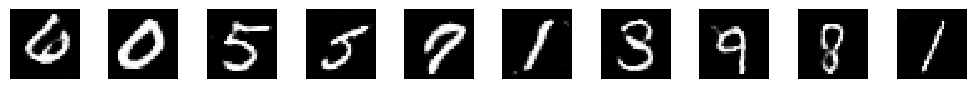

Epoch: 325, Time: 14.568786382675171, BPS: 4.11839383350081, Generator Loss: 0.7778766963441494, Discriminator Loss: 0.67554512468435
Epoch: 330, Time: 14.620734691619873, BPS: 4.103760943996202, Generator Loss: 0.7727624582032026, Discriminator Loss: 0.6756756265284651


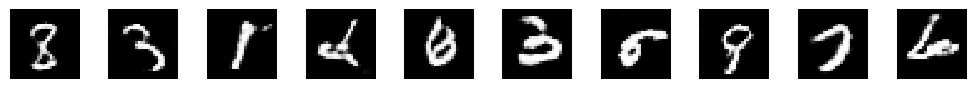

Epoch: 335, Time: 14.616390228271484, BPS: 4.104980714317965, Generator Loss: 0.7689422177056134, Discriminator Loss: 0.6742716158850718
Epoch: 340, Time: 14.632812738418579, BPS: 4.100373665171664, Generator Loss: 0.7695261335979073, Discriminator Loss: 0.6774531926138926


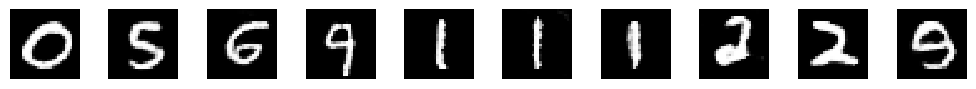

Epoch: 345, Time: 14.558279275894165, BPS: 4.121366190532488, Generator Loss: 0.7610465126522516, Discriminator Loss: 0.6731866779973952
Epoch: 350, Time: 14.595168590545654, BPS: 4.110949430133088, Generator Loss: 0.7721807451571449, Discriminator Loss: 0.6763149449380778


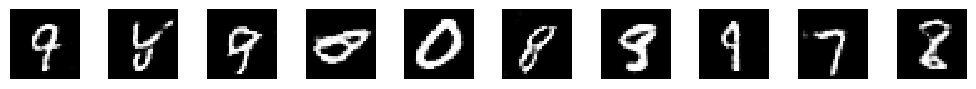

Epoch: 355, Time: 14.678409814834595, BPS: 4.087636246493239, Generator Loss: 0.7615335129075131, Discriminator Loss: 0.6746502902548192
Epoch: 360, Time: 14.661402702331543, BPS: 4.092377872579576, Generator Loss: 0.7693591592675548, Discriminator Loss: 0.6758432448920557


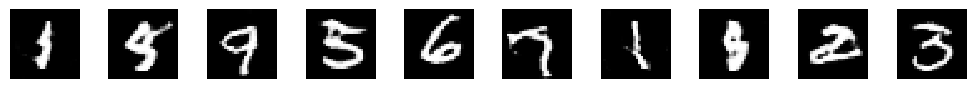

Epoch: 365, Time: 14.606295347213745, BPS: 4.10781779867579, Generator Loss: 0.7596368355266119, Discriminator Loss: 0.6746142304549783
Epoch: 370, Time: 14.604215860366821, BPS: 4.108402708756795, Generator Loss: 0.7603057754241814, Discriminator Loss: 0.6759104759006177


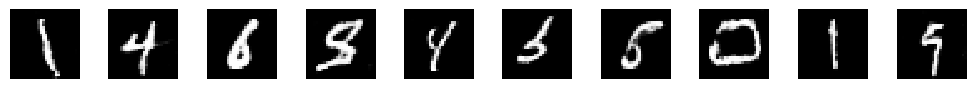

Epoch: 375, Time: 14.614826202392578, BPS: 4.105420014517686, Generator Loss: 0.7659192812644829, Discriminator Loss: 0.6773734325069493
Epoch: 380, Time: 14.663213014602661, BPS: 4.091872629842298, Generator Loss: 0.7860745524956008, Discriminator Loss: 0.6771403429871898


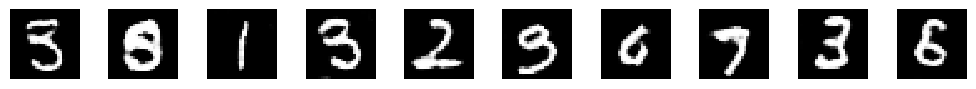

Epoch: 385, Time: 14.631998777389526, BPS: 4.100601764177055, Generator Loss: 0.7606919680611562, Discriminator Loss: 0.675692813881373
Epoch: 390, Time: 14.604315757751465, BPS: 4.108374606195027, Generator Loss: 0.7558659284801806, Discriminator Loss: 0.6749293723348844


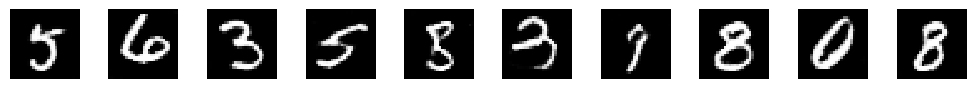

Epoch: 395, Time: 14.692494630813599, BPS: 4.083717674067817, Generator Loss: 0.7585581419831615, Discriminator Loss: 0.6753293942596953
Epoch: 400, Time: 14.70331621170044, BPS: 4.080712074481121, Generator Loss: 0.7643260420378992, Discriminator Loss: 0.6756193051903935


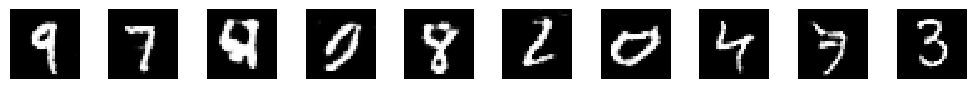

Epoch: 405, Time: 14.681452989578247, BPS: 4.086788960370034, Generator Loss: 0.7647730263613038, Discriminator Loss: 0.6755765878548057
Epoch: 410, Time: 14.695595502853394, BPS: 4.08285598146397, Generator Loss: 0.764989164926238, Discriminator Loss: 0.6779964192438934


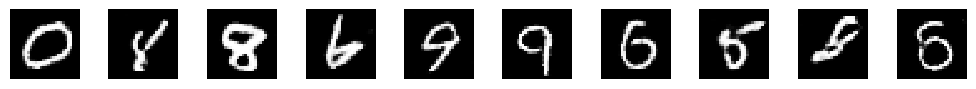

Epoch: 415, Time: 14.712470054626465, BPS: 4.07817312641751, Generator Loss: 0.7631635079949589, Discriminator Loss: 0.6762383307440806
Epoch: 420, Time: 14.732988595962524, BPS: 4.072493480137668, Generator Loss: 0.7524396171004085, Discriminator Loss: 0.6748615978127819


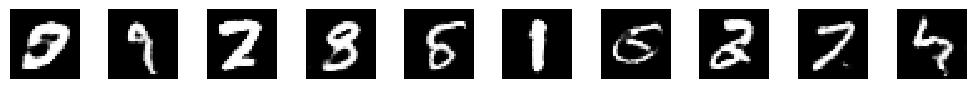

Epoch: 425, Time: 14.62493371963501, BPS: 4.102582695431005, Generator Loss: 0.7594862711631646, Discriminator Loss: 0.6762140787253945
Epoch: 430, Time: 14.622195482254028, BPS: 4.10335096893062, Generator Loss: 0.7842393123497398, Discriminator Loss: 0.6789527717283217


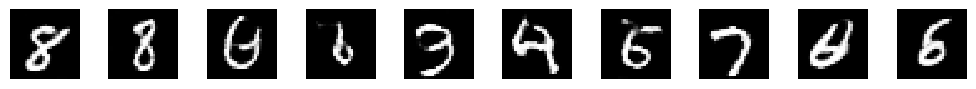

Epoch: 435, Time: 14.614086151123047, BPS: 4.105627911286755, Generator Loss: 0.7631620097968538, Discriminator Loss: 0.6770308745109429
Epoch: 440, Time: 14.634414434432983, BPS: 4.099924890662338, Generator Loss: 0.7561461864891699, Discriminator Loss: 0.6749640006130024


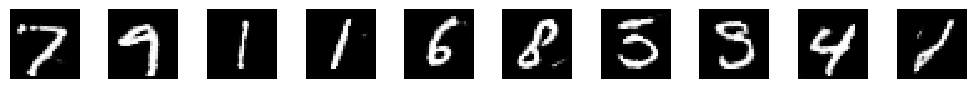

Epoch: 445, Time: 14.638849258422852, BPS: 4.098682822727845, Generator Loss: 0.7608193250025733, Discriminator Loss: 0.6768964498730029
Epoch: 450, Time: 14.593132734298706, BPS: 4.111522939757828, Generator Loss: 0.7554673017081568, Discriminator Loss: 0.6758991772845641


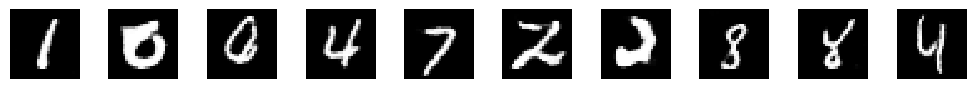

Epoch: 455, Time: 14.586504220962524, BPS: 4.113391330170319, Generator Loss: 0.762415130259627, Discriminator Loss: 0.6769449337054108
Epoch: 460, Time: 14.581087350845337, BPS: 4.114919453967986, Generator Loss: 0.7528938216678167, Discriminator Loss: 0.676324589777801


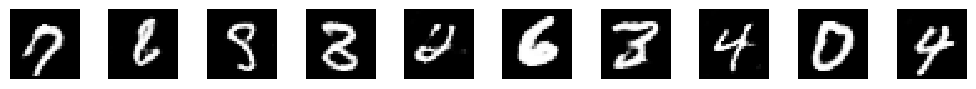

Epoch: 465, Time: 14.86425495147705, BPS: 4.0365292573266744, Generator Loss: 0.768765427298465, Discriminator Loss: 0.678685188293457
Epoch: 470, Time: 14.627947568893433, BPS: 4.101737425391856, Generator Loss: 0.7612972229214038, Discriminator Loss: 0.6775818820727073


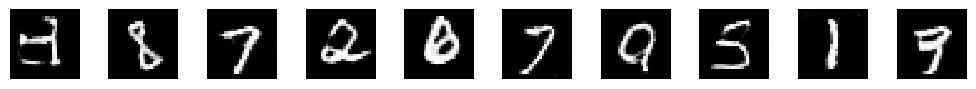

Epoch: 475, Time: 14.600833415985107, BPS: 4.109354465636977, Generator Loss: 0.7535367587865409, Discriminator Loss: 0.6765168177879463
Epoch: 480, Time: 14.73514199256897, BPS: 4.071898325123599, Generator Loss: 0.757442514775163, Discriminator Loss: 0.6772349537429163


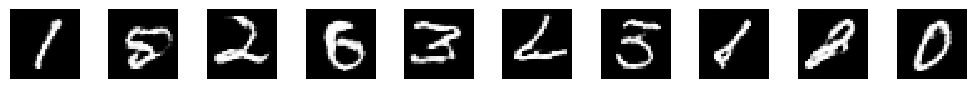

Epoch: 485, Time: 14.597975969314575, BPS: 4.11015884161763, Generator Loss: 0.7550703883171082, Discriminator Loss: 0.6777052657078888
Epoch: 490, Time: 14.625670433044434, BPS: 4.102376043182219, Generator Loss: 0.7650621371754145, Discriminator Loss: 0.6780155129351858


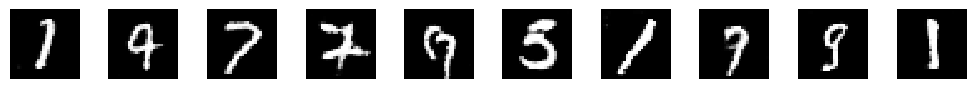

Epoch: 495, Time: 14.629401683807373, BPS: 4.101329726041449, Generator Loss: 0.7522430369409464, Discriminator Loss: 0.6770904023768538
Epoch: 500, Time: 14.598564386367798, BPS: 4.109993175495274, Generator Loss: 0.7503021995900041, Discriminator Loss: 0.675997952283439


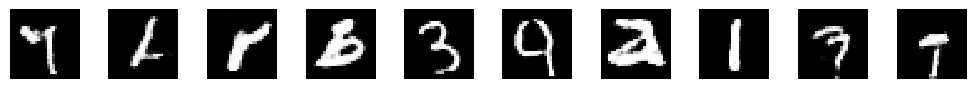

Epoch: 505, Time: 14.600019216537476, BPS: 4.109583632056995, Generator Loss: 0.7601971666691667, Discriminator Loss: 0.6782040272728872
Epoch: 510, Time: 14.597054481506348, BPS: 4.1104183091196, Generator Loss: 0.7512695950976873, Discriminator Loss: 0.6777262041124247


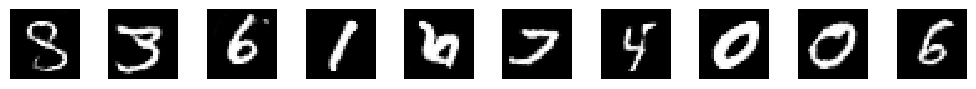

Epoch: 515, Time: 14.601179361343384, BPS: 4.1092571028097895, Generator Loss: 0.761304604805122, Discriminator Loss: 0.6784366136890346
Epoch: 520, Time: 14.802349328994751, BPS: 4.053410621952582, Generator Loss: 0.7553640583814201, Discriminator Loss: 0.6774775961698112


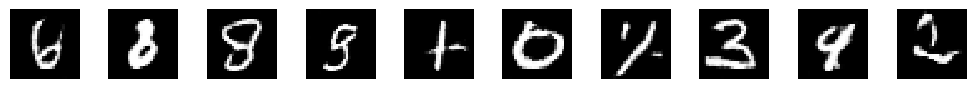

Epoch: 525, Time: 14.655733108520508, BPS: 4.093961015509853, Generator Loss: 0.7532110355668149, Discriminator Loss: 0.6775147541094635
Epoch: 530, Time: 20.47991418838501, BPS: 2.9296997755014242, Generator Loss: 0.755383252087286, Discriminator Loss: 0.6777655088295371


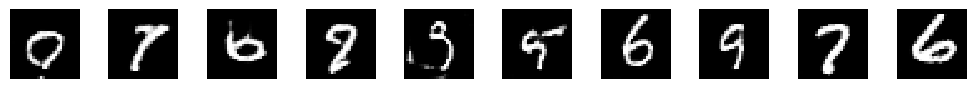

Epoch: 535, Time: 14.67469048500061, BPS: 4.088672266125653, Generator Loss: 0.7553582322799554, Discriminator Loss: 0.6786324907157381
Epoch: 540, Time: 14.704726934432983, BPS: 4.080320584498743, Generator Loss: 0.7511801770177938, Discriminator Loss: 0.678328434289512


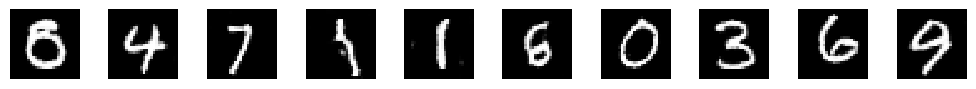

Epoch: 545, Time: 14.688444375991821, BPS: 4.084843735941817, Generator Loss: 0.7498253846572618, Discriminator Loss: 0.6768221592499037
Epoch: 550, Time: 14.651591300964355, BPS: 4.095118323157898, Generator Loss: 0.7515425793195175, Discriminator Loss: 0.677639434903355


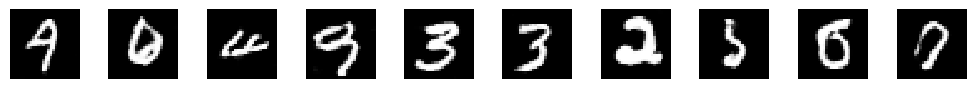

Epoch: 555, Time: 14.637143850326538, BPS: 4.099160369914754, Generator Loss: 0.7483252499063137, Discriminator Loss: 0.6775418641203541
Epoch: 560, Time: 14.585146427154541, BPS: 4.113774263403509, Generator Loss: 0.7489231956207146, Discriminator Loss: 0.6775752578751516


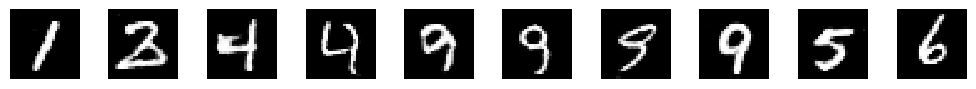

Epoch: 565, Time: 14.678702116012573, BPS: 4.087554848227878, Generator Loss: 0.7581379352989843, Discriminator Loss: 0.6797263147467274
Epoch: 570, Time: 15.449807167053223, BPS: 3.883543616515179, Generator Loss: 0.7518714646161613, Discriminator Loss: 0.6779124615556102


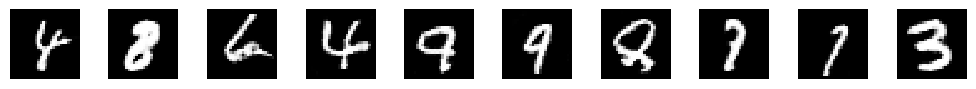

Epoch: 575, Time: 15.342386245727539, BPS: 3.9107345519155117, Generator Loss: 0.7500709436707578, Discriminator Loss: 0.6783120238174827
Epoch: 580, Time: 14.536295175552368, BPS: 4.127599176777177, Generator Loss: 0.7529265254230822, Discriminator Loss: 0.6775509583747993


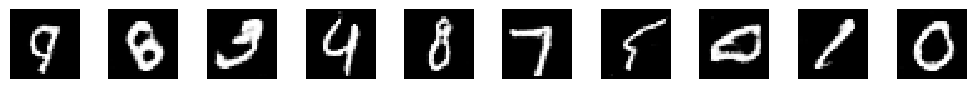

Epoch: 585, Time: 14.705878496170044, BPS: 4.080001070022863, Generator Loss: 0.7521939257443961, Discriminator Loss: 0.6799756733037657
Epoch: 590, Time: 14.593116998672485, BPS: 4.111527373175869, Generator Loss: 0.7558558856026601, Discriminator Loss: 0.6815558823488527


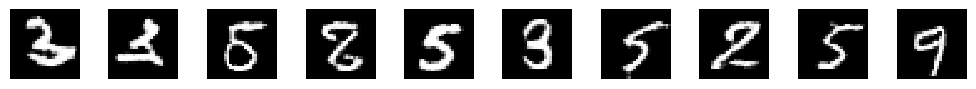

Epoch: 595, Time: 14.585718393325806, BPS: 4.113612945348996, Generator Loss: 0.7539826621443538, Discriminator Loss: 0.678947846768266
Epoch: 600, Time: 14.582277536392212, BPS: 4.114583599870541, Generator Loss: 0.7469528943805371, Discriminator Loss: 0.6785235748452655


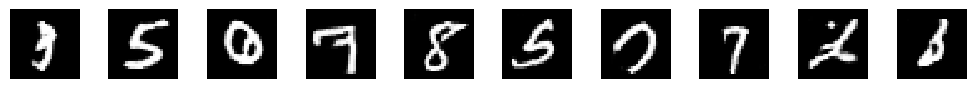

Epoch: 605, Time: 14.58335542678833, BPS: 4.114279481235527, Generator Loss: 0.7425508862834865, Discriminator Loss: 0.6792850898484052
Epoch: 610, Time: 14.592140913009644, BPS: 4.111802398132471, Generator Loss: 0.7461247080463475, Discriminator Loss: 0.6787501371512978


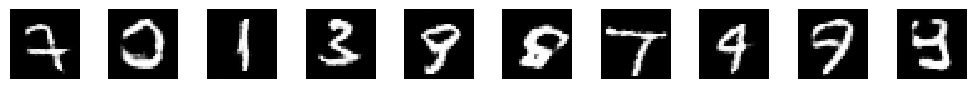

Epoch: 615, Time: 14.55939245223999, BPS: 4.121051080724793, Generator Loss: 0.7467654852543847, Discriminator Loss: 0.6779185695163275
Epoch: 620, Time: 14.575317621231079, BPS: 4.116548370280538, Generator Loss: 0.7439997640706725, Discriminator Loss: 0.6785303637132807


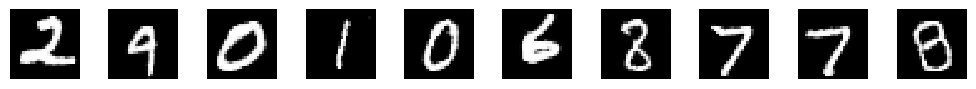

Epoch: 625, Time: 14.57266092300415, BPS: 4.117298845901577, Generator Loss: 0.7460681381872145, Discriminator Loss: 0.679243546421245
Epoch: 630, Time: 14.577800989151001, BPS: 4.115847105105415, Generator Loss: 0.7460952532493462, Discriminator Loss: 0.6784578874959784


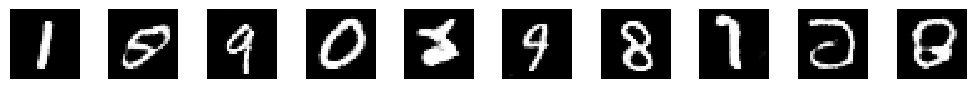

Epoch: 635, Time: 14.570461511611938, BPS: 4.117920352226521, Generator Loss: 0.7455493080413947, Discriminator Loss: 0.6792549177751703
Epoch: 640, Time: 14.612024784088135, BPS: 4.106207105899342, Generator Loss: 0.746895530466306, Discriminator Loss: 0.6788051431461916


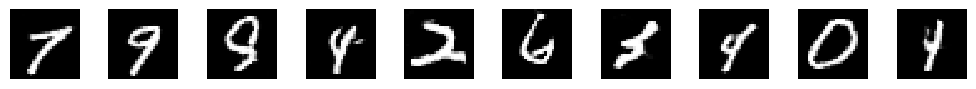

Epoch: 645, Time: 14.629136085510254, BPS: 4.101404187457679, Generator Loss: 0.7465858156398192, Discriminator Loss: 0.6798841832047802
Epoch: 650, Time: 14.569974184036255, BPS: 4.118058085905164, Generator Loss: 0.7478003350354857, Discriminator Loss: 0.6802134756314553


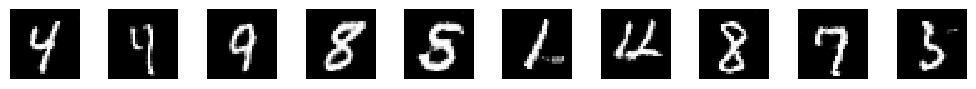

Epoch: 655, Time: 14.535362005233765, BPS: 4.127864168666438, Generator Loss: 0.746956141318305, Discriminator Loss: 0.6804039549019377
Epoch: 660, Time: 14.565864324569702, BPS: 4.119220024505651, Generator Loss: 0.745727763337604, Discriminator Loss: 0.6795469785140733


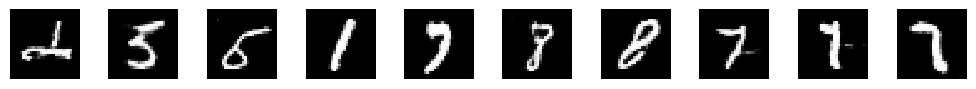

Epoch: 665, Time: 14.562386751174927, BPS: 4.120203715586599, Generator Loss: 0.7465139778993898, Discriminator Loss: 0.6794530203786947
Epoch: 670, Time: 14.556911706924438, BPS: 4.121753377913199, Generator Loss: 0.7506009168544058, Discriminator Loss: 0.6798888283260798


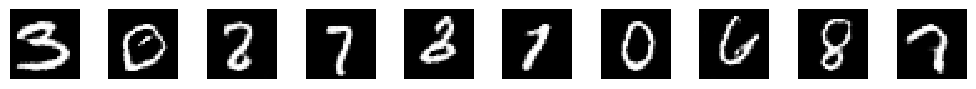

Epoch: 675, Time: 14.583566427230835, BPS: 4.114219954315589, Generator Loss: 0.7414647896411055, Discriminator Loss: 0.6792979927386268
Epoch: 680, Time: 14.573856353759766, BPS: 4.116961121585447, Generator Loss: 0.7449566802736056, Discriminator Loss: 0.6785722637580613


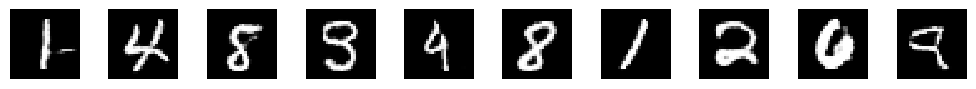

Epoch: 685, Time: 14.570084810256958, BPS: 4.118026818743126, Generator Loss: 0.7442359782881656, Discriminator Loss: 0.6803634469791994
Epoch: 690, Time: 14.545495748519897, BPS: 4.124988315101286, Generator Loss: 0.7407219127073126, Discriminator Loss: 0.6790720790119494


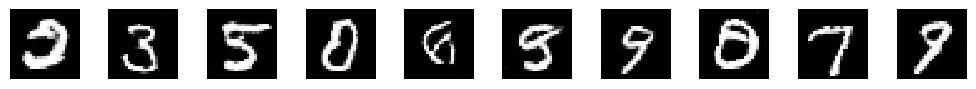

Epoch: 695, Time: 14.619577169418335, BPS: 4.104085864091185, Generator Loss: 0.7421660625328452, Discriminator Loss: 0.6801402831481675
Epoch: 700, Time: 14.559935092926025, BPS: 4.120897491442192, Generator Loss: 0.7445111648511078, Discriminator Loss: 0.6791711813312465


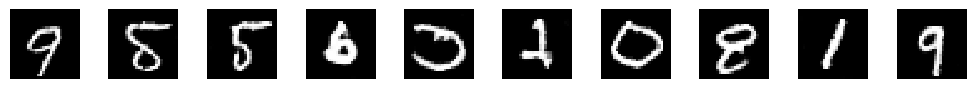

Epoch: 705, Time: 14.56948733329773, BPS: 4.118195694015495, Generator Loss: 0.7402574409872799, Discriminator Loss: 0.6793291215169228
Epoch: 710, Time: 14.580545425415039, BPS: 4.115072396085765, Generator Loss: 0.7464555592860206, Discriminator Loss: 0.6802528722811554


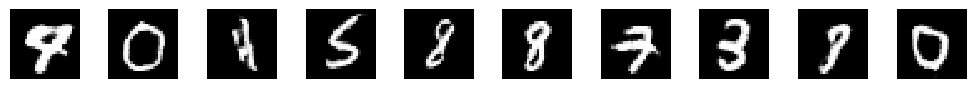

Epoch: 715, Time: 14.596717119216919, BPS: 4.110513309942042, Generator Loss: 0.7416441662836883, Discriminator Loss: 0.6802454782744586
Epoch: 720, Time: 14.59507131576538, BPS: 4.110976829225143, Generator Loss: 0.744276874146219, Discriminator Loss: 0.6800065586122416


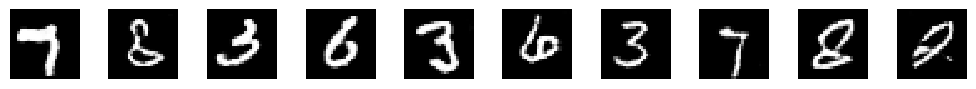

Epoch: 725, Time: 14.568146705627441, BPS: 4.118574669269562, Generator Loss: 0.7622649790877003, Discriminator Loss: 0.6829650311146752
Epoch: 730, Time: 14.557775020599365, BPS: 4.121508947287586, Generator Loss: 0.7421549073720383, Discriminator Loss: 0.6800405059830618


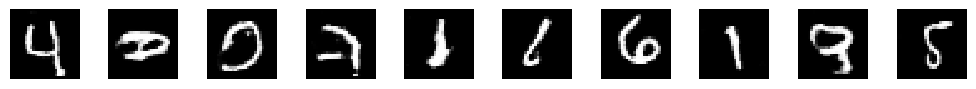

Epoch: 735, Time: 14.566798448562622, BPS: 4.118955871591709, Generator Loss: 0.7412196458396265, Discriminator Loss: 0.679617045289379
Epoch: 740, Time: 14.607592821121216, BPS: 4.1074529345619215, Generator Loss: 0.7415248590000605, Discriminator Loss: 0.6795939833430921


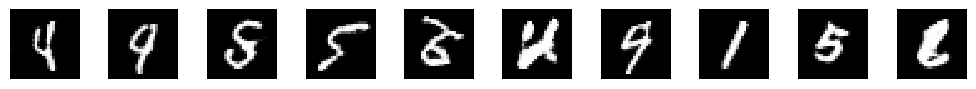

Epoch: 745, Time: 14.538517475128174, BPS: 4.1269682484919965, Generator Loss: 0.7427457581132145, Discriminator Loss: 0.6808825104923572
Epoch: 750, Time: 14.576427459716797, BPS: 4.116234939309726, Generator Loss: 0.7485836380619114, Discriminator Loss: 0.6810345063775273


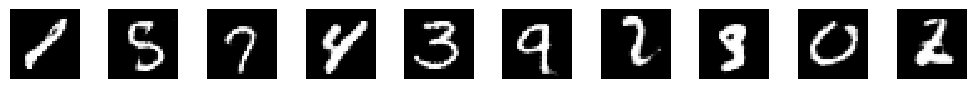

Epoch: 755, Time: 14.558589935302734, BPS: 4.121278246494711, Generator Loss: 0.7385071990853649, Discriminator Loss: 0.6796102331856549
Epoch: 760, Time: 14.567226648330688, BPS: 4.118834795975088, Generator Loss: 0.7428183070683884, Discriminator Loss: 0.6807806592876628


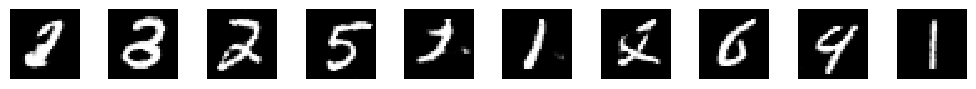

Epoch: 765, Time: 14.552209615707397, BPS: 4.12308519355281, Generator Loss: 0.7404083205481707, Discriminator Loss: 0.6809595166626623
Epoch: 770, Time: 14.60166311264038, BPS: 4.109120963629078, Generator Loss: 0.7436445971666756, Discriminator Loss: 0.6813635543241339


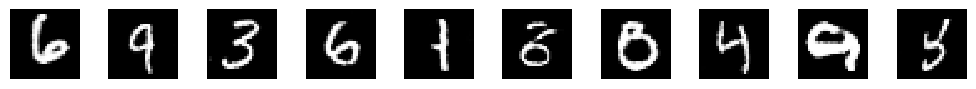

Epoch: 775, Time: 14.573988914489746, BPS: 4.116923674914204, Generator Loss: 0.739459295394057, Discriminator Loss: 0.6817346851704484
Epoch: 780, Time: 14.62656307220459, BPS: 4.102125680777343, Generator Loss: 0.7428424004781045, Discriminator Loss: 0.6822873838877274


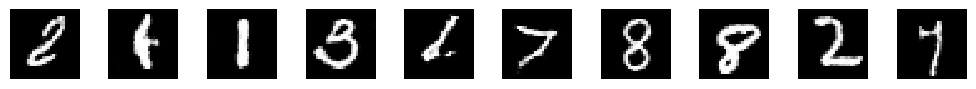

Epoch: 785, Time: 14.572150707244873, BPS: 4.117443005181771, Generator Loss: 0.7420586509219671, Discriminator Loss: 0.680593187526121
Epoch: 790, Time: 14.548124551773071, BPS: 4.124242941863419, Generator Loss: 0.751135150254783, Discriminator Loss: 0.682719153872991


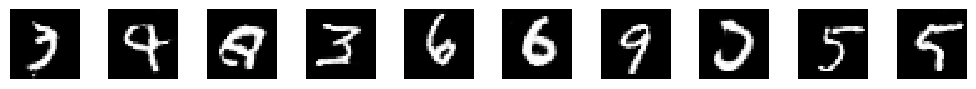

Epoch: 795, Time: 14.562947034835815, BPS: 4.120045198027217, Generator Loss: 0.7408950116674778, Discriminator Loss: 0.6818616339715861
Epoch: 800, Time: 14.556058406829834, BPS: 4.1219950018782185, Generator Loss: 0.7397808685141095, Discriminator Loss: 0.6803095492265993


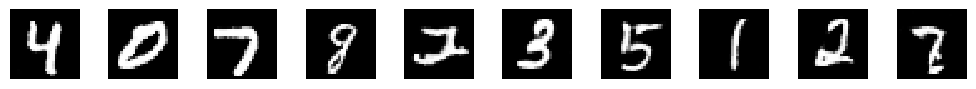

Epoch: 805, Time: 14.589935779571533, BPS: 4.112423858918592, Generator Loss: 0.739587888879291, Discriminator Loss: 0.6802468764579902
Epoch: 810, Time: 14.559347152709961, BPS: 4.121063902843479, Generator Loss: 0.7421104130098375, Discriminator Loss: 0.6813033475714215


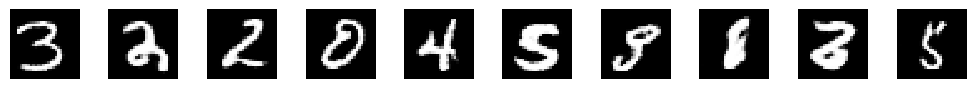

Epoch: 815, Time: 14.528707265853882, BPS: 4.1297548984977555, Generator Loss: 0.7445344823901936, Discriminator Loss: 0.681326379210262
Epoch: 820, Time: 14.608057737350464, BPS: 4.107322210713175, Generator Loss: 0.7458792146989854, Discriminator Loss: 0.6813590829655275


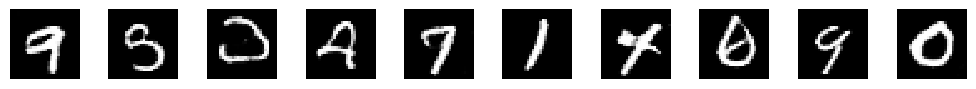

Epoch: 825, Time: 14.611076354980469, BPS: 4.106473646587155, Generator Loss: 0.7392000252917662, Discriminator Loss: 0.6808423894946858
Epoch: 830, Time: 14.599040985107422, BPS: 4.109859001095099, Generator Loss: 0.7406646043567334, Discriminator Loss: 0.6811915141040996


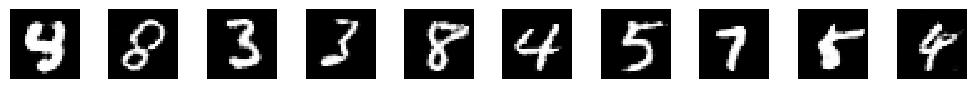

Epoch: 835, Time: 14.588989734649658, BPS: 4.11269053521209, Generator Loss: 0.7379548559754582, Discriminator Loss: 0.6805858076628992
Epoch: 840, Time: 14.61834192276001, BPS: 4.104432658438716, Generator Loss: 0.7392867652036376, Discriminator Loss: 0.6817389979200849


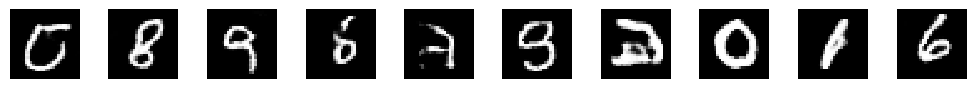

Epoch: 845, Time: 14.569200277328491, BPS: 4.118276834547161, Generator Loss: 0.733809853004197, Discriminator Loss: 0.6804317296561548
Epoch: 850, Time: 14.585262537002563, BPS: 4.113741514613194, Generator Loss: 0.7424769926879365, Discriminator Loss: 0.6817057617640091


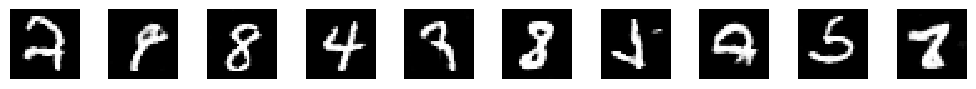

Epoch: 855, Time: 14.622767210006714, BPS: 4.103190534206176, Generator Loss: 0.7380327147952581, Discriminator Loss: 0.6808015936512058
Epoch: 860, Time: 14.5636568069458, BPS: 4.1198444041461055, Generator Loss: 0.7419106040970754, Discriminator Loss: 0.6823335007085638


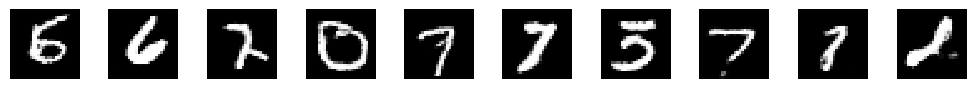

Epoch: 865, Time: 14.593804359436035, BPS: 4.1113337223275375, Generator Loss: 0.738750943693064, Discriminator Loss: 0.6820102313817558
Epoch: 870, Time: 14.641240119934082, BPS: 4.098013522659865, Generator Loss: 0.7373320318884768, Discriminator Loss: 0.6820610327235723


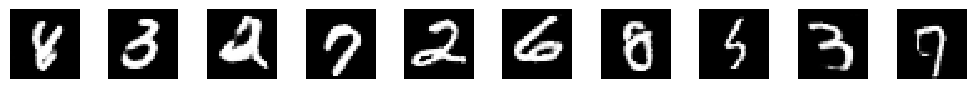

Epoch: 875, Time: 14.595689296722412, BPS: 4.11080277061485, Generator Loss: 0.7411907416279033, Discriminator Loss: 0.6817479436680421
Epoch: 880, Time: 14.560844898223877, BPS: 4.120640005396854, Generator Loss: 0.7403260742203664, Discriminator Loss: 0.6815753528627299


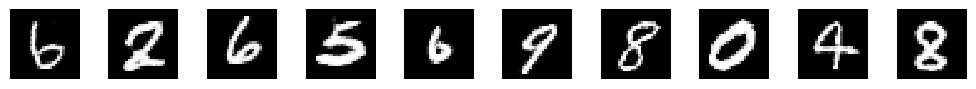

Epoch: 885, Time: 14.596479177474976, BPS: 4.110580316696572, Generator Loss: 0.7367828538862325, Discriminator Loss: 0.6813968349311311
Epoch: 890, Time: 14.82376742362976, BPS: 4.04755405865025, Generator Loss: 0.7386884941893109, Discriminator Loss: 0.6813195610450486


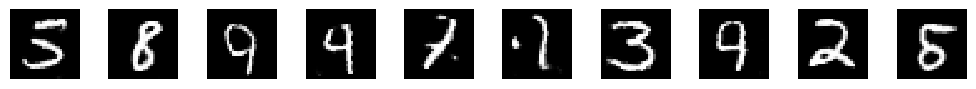

Epoch: 895, Time: 15.041422843933105, BPS: 3.9889843283144417, Generator Loss: 0.7351716524463588, Discriminator Loss: 0.6815086188962904
Epoch: 900, Time: 14.835758447647095, BPS: 4.044282617011455, Generator Loss: 0.7351337529845157, Discriminator Loss: 0.6812496993501308


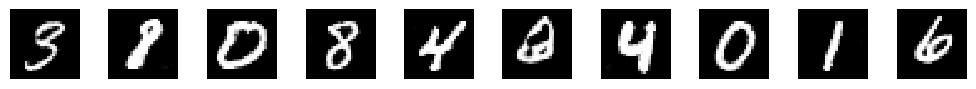

Epoch: 905, Time: 14.914765357971191, BPS: 4.022859130528193, Generator Loss: 0.7346592990018553, Discriminator Loss: 0.681283460835279
Epoch: 910, Time: 14.885618686676025, BPS: 4.030736058938916, Generator Loss: 0.7364088054430686, Discriminator Loss: 0.6819605190875166


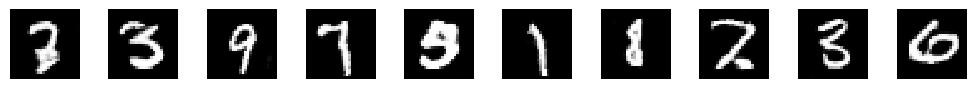

Epoch: 915, Time: 14.907171726226807, BPS: 4.024908352966747, Generator Loss: 0.7385950886597068, Discriminator Loss: 0.6830657346773956
Epoch: 920, Time: 14.988593339920044, BPS: 4.003044090881985, Generator Loss: 0.7336857480517889, Discriminator Loss: 0.6824279286093631


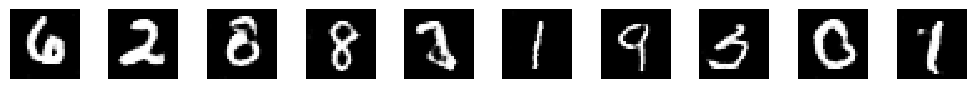

Epoch: 925, Time: 14.919172286987305, BPS: 4.021670830380636, Generator Loss: 0.7384435190992841, Discriminator Loss: 0.6817472233610639
Epoch: 930, Time: 14.904097080230713, BPS: 4.025738672863718, Generator Loss: 0.7355960405479043, Discriminator Loss: 0.6819054807646799


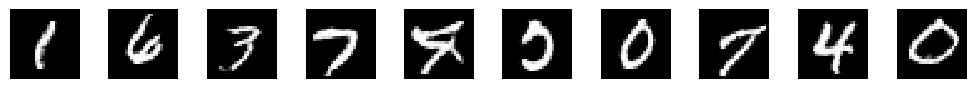

Epoch: 935, Time: 14.904224872589111, BPS: 4.025704155225686, Generator Loss: 0.7395807747113503, Discriminator Loss: 0.6820391770136558
Epoch: 940, Time: 14.934912204742432, BPS: 4.017432387781135, Generator Loss: 0.7372043031757161, Discriminator Loss: 0.6837545138294414


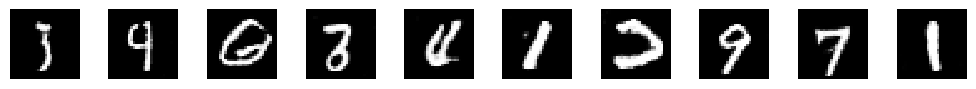

Epoch: 945, Time: 14.995712757110596, BPS: 4.001143591627513, Generator Loss: 0.7373454924357139, Discriminator Loss: 0.6829361693333771
Epoch: 950, Time: 15.02409029006958, BPS: 3.9935862232975254, Generator Loss: 0.7363555936490075, Discriminator Loss: 0.6822245494794037


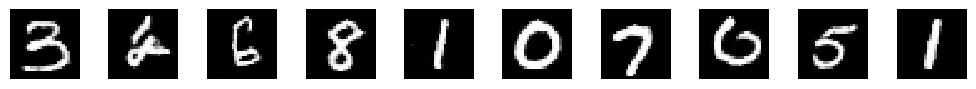

Epoch: 955, Time: 15.039683103561401, BPS: 3.9894457607149967, Generator Loss: 0.7341364339246588, Discriminator Loss: 0.6821862075288417
Epoch: 960, Time: 14.983931064605713, BPS: 4.004289644773459, Generator Loss: 0.7337495017859895, Discriminator Loss: 0.6824158288664737


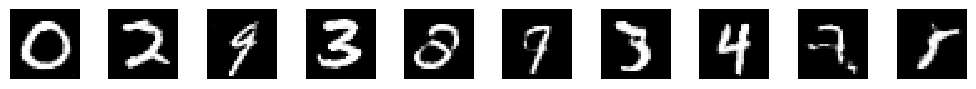

Epoch: 965, Time: 14.929131269454956, BPS: 4.0189880386918535, Generator Loss: 0.7369309017213724, Discriminator Loss: 0.682704219373606
Epoch: 970, Time: 14.982424974441528, BPS: 4.0046921711507855, Generator Loss: 0.7503926046824051, Discriminator Loss: 0.6851429424043429


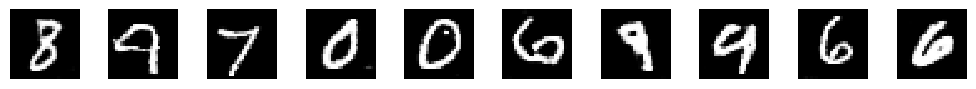

Epoch: 975, Time: 14.829139709472656, BPS: 4.046087714830335, Generator Loss: 0.7363128470162214, Discriminator Loss: 0.6833241450584541
Epoch: 980, Time: 14.853927850723267, BPS: 4.039335629133171, Generator Loss: 0.7376675050137407, Discriminator Loss: 0.6828332795935163


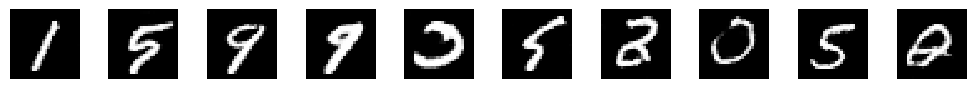

Epoch: 985, Time: 14.89723539352417, BPS: 4.027592933523895, Generator Loss: 0.7322652764239553, Discriminator Loss: 0.6824903084059893
Epoch: 990, Time: 14.643866300582886, BPS: 4.097278599000303, Generator Loss: 0.7334874999725213, Discriminator Loss: 0.6819684505462646


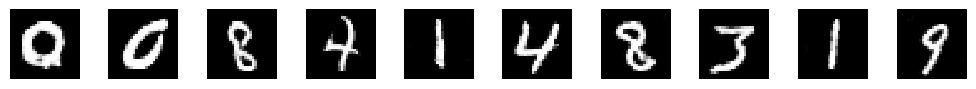

Epoch: 995, Time: 14.628711223602295, BPS: 4.101523304608996, Generator Loss: 0.733291731042377, Discriminator Loss: 0.6814137272915598


In [8]:
dlosses = []
glosses = []

for epoch in range(EPOCHS):
    dloss = []
    gloss = []
    t = time.time()
    i = 1
    for batch in ds.batch(BATCH_SIZE):
        i += 1
        batch_size = batch.shape[0]
        noise = generate_z(batch_size)
        generated_images = g.predict(noise, verbose=0)
        X = tf.concat([batch, generated_images], axis=0)
        y_dis = tf.concat([tf.ones(batch_size, dtype=tf.float32), tf.zeros(batch_size, dtype=tf.float32)], axis=0)

        d.trainable = True

        dloss.append(d.train_on_batch(X, y_dis))

        noise = generate_z(batch_size)
        y_gen = tf.ones(batch_size, dtype=tf.float32)
        d.trainable = False
        gloss.append(gan.train_on_batch(noise, y_gen))

    dlosses.append(np.mean(dloss))
    glosses.append(np.mean(gloss))
    dt = time.time() - t
    bps = i / dt
    if epoch % 5 == 0:
        print(
            f"Epoch: {epoch}, Time: {dt}, BPS: {bps}, Generator Loss: {np.mean(gloss)}, Discriminator Loss: {np.mean(dloss)}"
        )
    if epoch % 10 == 0:
        plot_generated_images(g)

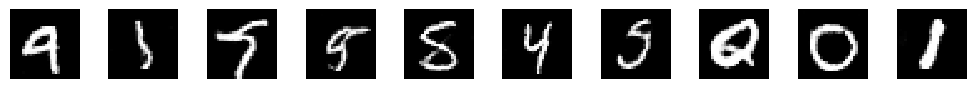

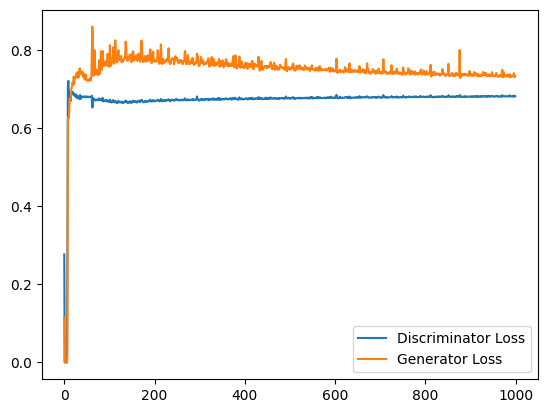

In [9]:
plot_generated_images(g)

plt.plot(dlosses, label="Discriminator Loss")
plt.plot(glosses, label="Generator Loss")
plt.legend()
plt.show()

In [10]:
g.save("generator.h5")
d.save("discriminator.h5")
gan.save("gan.h5")
